In [ ]:
import torch
import torch.nn
import source.number_representation
import matplotlib.pyplot as plt

torch.manual_seed(42)

In [165]:
def create_test_scenario(
    function_to_approximate,
    dataset_size = 1000,
    train_range = (0, 10),
    test_range = (5, 15),
    train_size = 0.5
):
    X_train_set = torch.rand(int(dataset_size * train_size)) * (train_range[1] - train_range[0]) + train_range[0]
    Y_train_set = function_to_approximate(X_train_set)

    X_test_set = torch.rand(int(dataset_size * (1 - train_size))) * (test_range[1] - test_range[0]) + test_range[0]
    Y_test_set = function_to_approximate(X_test_set)

    return (X_train_set, Y_train_set), (X_test_set, Y_test_set)

def get_network_and_optimizer(input_size: int = 256):
    network = torch.nn.Sequential(
        torch.nn.Linear(input_size, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1),
    )
    optimizer = torch.optim.AdamW(network.parameters(), lr=1e-6)
    return network, optimizer

def train_network(train_dataloader, network, optimizer, n_epochs: int = 8):
    losses = []
    for _ in range(n_epochs):
        for X, y in train_dataloader:
            loss = torch.nn.functional.mse_loss(
                network(X),
                y
            )
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losses.append(loss.item())
    return losses

@torch.no_grad()
def test_network(test_dataloader, network):
    count = 0
    cumulative_loss = 0
    for X, y in test_dataloader:
        loss = torch.nn.functional.mse_loss(
            network(X),
            y,
            reduction='sum'
        )
        cumulative_loss += loss
        count += X.shape[0]
    return (cumulative_loss / count).item()

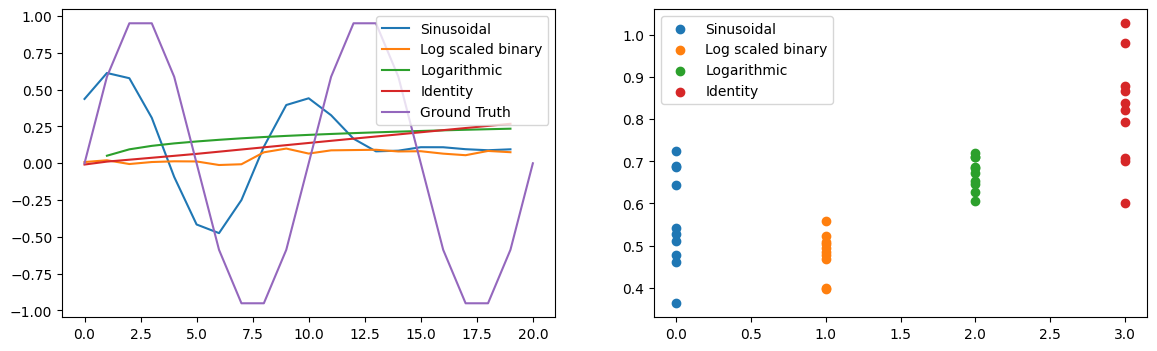

In [166]:
## 1 Test case: approximation of periodic function, e.g. sin
embedding_size = 256
function_range = 15
function_to_approximate = lambda x : torch.sin(x * 4 * torch.pi / function_range)

name_to_encoding_type = {
    'Sinusoidal': source.number_representation.sinusoidal_encoding,
    'Log scaled binary': source.number_representation.log_scaled_binary_encoding,
    'Logarithmic': source.number_representation.logarithmic_encoding,
    'Identity': source.number_representation.identity_encoding
}

encoding_to_results = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

encoding_to_validation_predictions = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

for encoding_name, encoding_type in name_to_encoding_type.items():
    embedding_function = lambda x : (encoding_type(x, embedding_size=embedding_size))
    (X_train_set, Y_train_set), (X_test_set, Y_test_set) = create_test_scenario(
        function_to_approximate,
        train_range = (0, 10),
        test_range = (10, 15)
    )
    train_dataset = torch.utils.data.TensorDataset(embedding_function(X_train_set), Y_train_set.unsqueeze(1))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(embedding_function(X_test_set), Y_test_set.unsqueeze(1))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True)

    for _ in range(10):
        network, optimizer = get_network_and_optimizer(input_size=embedding_size)
        train_losses = train_network(train_dataloader=train_dataloader, network=network, optimizer=optimizer)
        encoding_to_results[encoding_name].append(test_network(test_dataloader=test_dataloader, network=network))

    with torch.no_grad():
        encoding_to_validation_predictions[encoding_name].extend(
            network(embedding_function(torch.arange(20))).flatten().tolist()
        )

inputs = torch.arange(21) * function_range / 20
ground_truth = function_to_approximate(inputs)

figure = plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)

for encoding_name, _ in name_to_encoding_type.items():
    predictions = encoding_to_validation_predictions[encoding_name]
    plt.plot(predictions, label=encoding_name)

plt.plot(ground_truth, label="Ground Truth")
plt.legend()

plt.subplot(1, 2, 2)
for index, (encoding_name, _) in enumerate(name_to_encoding_type.items()):
    test_results = encoding_to_results[encoding_name]
    plt.scatter(x = [index]*len(test_results), y = test_results, label=encoding_name)
plt.legend()

plt.show()

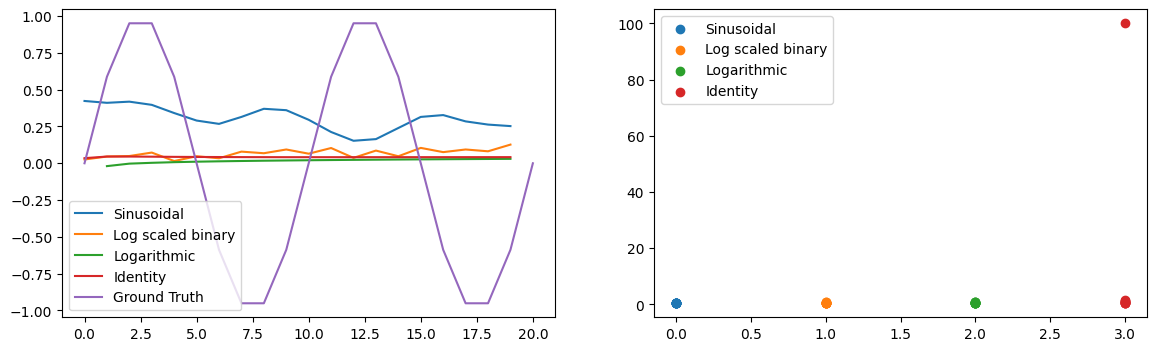

In [167]:
## 1 Test case: approximation of periodic function, e.g. sin
embedding_size = 256
function_range = 15000
function_to_approximate = lambda x : torch.sin(x * 4 * torch.pi / function_range)

name_to_encoding_type = {
    'Sinusoidal': source.number_representation.sinusoidal_encoding,
    'Log scaled binary': source.number_representation.log_scaled_binary_encoding,
    'Logarithmic': source.number_representation.logarithmic_encoding,
    'Identity': source.number_representation.identity_encoding
}

encoding_to_results = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

encoding_to_validation_predictions = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

for encoding_name, encoding_type in name_to_encoding_type.items():
    embedding_function = lambda x : (encoding_type(x, embedding_size=embedding_size))
    (X_train_set, Y_train_set), (X_test_set, Y_test_set) = create_test_scenario(
        function_to_approximate,
        train_range = (0, 10000),
        test_range = (5000, 15000)
    )
    train_dataset = torch.utils.data.TensorDataset(embedding_function(X_train_set), Y_train_set.unsqueeze(1))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(embedding_function(X_test_set), Y_test_set.unsqueeze(1))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True)

    for _ in range(10):
        network, optimizer = get_network_and_optimizer(input_size=embedding_size)
        train_losses = train_network(train_dataloader=train_dataloader, network=network, optimizer=optimizer)
        encoding_to_results[encoding_name].append(test_network(test_dataloader=test_dataloader, network=network))

    with torch.no_grad():
        encoding_to_validation_predictions[encoding_name].extend(
            network(embedding_function(torch.arange(20))).flatten().tolist()
        )
    
inputs = torch.arange(21) * function_range / 20
ground_truth = function_to_approximate(inputs)

figure = plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)

for encoding_name, _ in name_to_encoding_type.items():
    predictions = encoding_to_validation_predictions[encoding_name]
    plt.plot(predictions, label=encoding_name)

plt.plot(ground_truth, label="Ground Truth")
plt.legend()

plt.subplot(1, 2, 2)
for index, (encoding_name, _) in enumerate(name_to_encoding_type.items()):
    test_results = encoding_to_results[encoding_name]
    plt.scatter(x = [index]*len(test_results), y = test_results, label=encoding_name)
plt.legend()

plt.show()

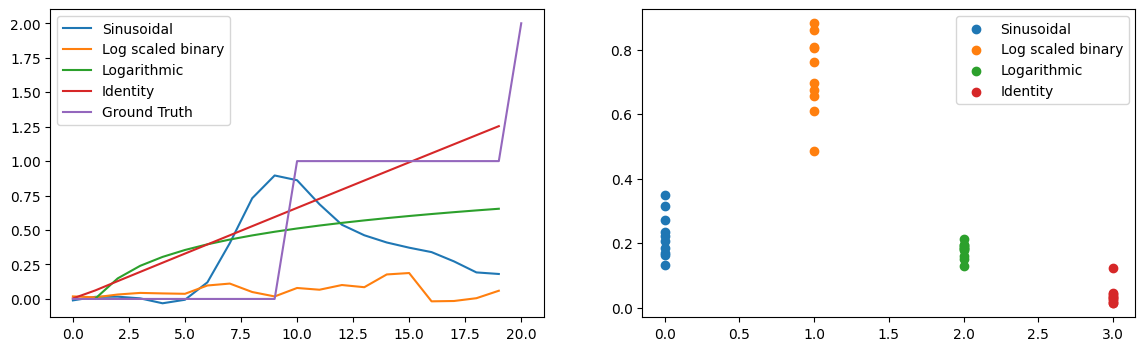

In [172]:
## 1 Test case: approximation of periodic function, e.g. sin
embedding_size = 256
function_range = 15
function_to_approximate = lambda x : (x / function_range) * 10 // 5

name_to_encoding_type = {
    'Sinusoidal': source.number_representation.sinusoidal_encoding,
    'Log scaled binary': source.number_representation.log_scaled_binary_encoding,
    'Logarithmic': source.number_representation.logarithmic_encoding,
    'Identity': source.number_representation.identity_encoding
}

encoding_to_results = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

encoding_to_validation_predictions = {
    'Sinusoidal': [],
    'Log scaled binary': [],
    'Logarithmic': [],
    'Identity': [],
}

for encoding_name, encoding_type in name_to_encoding_type.items():
    embedding_function = lambda x : (encoding_type(x, embedding_size=embedding_size))
    (X_train_set, Y_train_set), (X_test_set, Y_test_set) = create_test_scenario(
        function_to_approximate,
        train_range = (0, 10),
        test_range = (10, 15)
    )
    train_dataset = torch.utils.data.TensorDataset(embedding_function(X_train_set), Y_train_set.unsqueeze(1))
    train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(embedding_function(X_test_set), Y_test_set.unsqueeze(1))
    test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True)

    for _ in range(10):
        network, optimizer = get_network_and_optimizer(input_size=embedding_size)
        train_losses = train_network(train_dataloader=train_dataloader, network=network, optimizer=optimizer)
        encoding_to_results[encoding_name].append(test_network(test_dataloader=test_dataloader, network=network))

    with torch.no_grad():
        encoding_to_validation_predictions[encoding_name].extend(
            network(embedding_function(torch.arange(20))).flatten().tolist()
        )

inputs = torch.arange(21) * function_range / 20
ground_truth = function_to_approximate(inputs)

figure = plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)

for encoding_name, _ in name_to_encoding_type.items():
    predictions = encoding_to_validation_predictions[encoding_name]
    plt.plot(predictions, label=encoding_name)

plt.plot(ground_truth, label="Ground Truth")
plt.legend()

plt.subplot(1, 2, 2)
for index, (encoding_name, _) in enumerate(name_to_encoding_type.items()):
    test_results = encoding_to_results[encoding_name]
    plt.scatter(x = [index]*len(test_results), y = test_results, label=encoding_name)
plt.legend()

plt.show()